In [1]:
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

In [2]:
import os
import shutil
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
from tensorflow import keras


2025-09-04 03:06:30.780471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756955191.158536      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756955191.265994      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")

In [4]:
random.seed(42)
directory = '../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
images_path = Path('../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/')
path_ground_truth_data = '../input/isic-2019/ISIC_2019_Training_GroundTruth.csv'

In [5]:
ground_truth_labels = pd.read_csv(path_ground_truth_data)
ground_truth_labels

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
ground_truth_labels.describe()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
count,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.000000,25331.0
mean,0.178516,0.508270,0.131183,0.034227,0.103588,0.009435,0.009988,0.024792,0.0
std,0.382954,0.499941,0.337607,0.181815,0.304732,0.096677,0.099440,0.155493,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [7]:
CLASSES = ground_truth_labels.columns[1:-1].values
print(CLASSES)

['MEL' 'NV' 'BCC' 'AK' 'BKL' 'DF' 'VASC' 'SCC']


In [8]:
images = [path.as_posix() for path in list(images_path.rglob("*jpg"))]
labels = list()
for path in tqdm(images):
    name = path.split('/')[-1].split('.')[0]
    label = ground_truth_labels[ground_truth_labels.image == name].iloc[:,1:].values.argmax()
    labels.append(label)
classes = len(np.unique(labels))
assert len(images)==len(labels), 'Not equal number images and labels'

100%|██████████| 25331/25331 [01:05<00:00, 385.52it/s]


In [9]:
len(images)

25331

In [10]:
def plot_label_distribution(images, labels):
    # Count the frequency of each label
    label_counts = Counter(labels)
    
    # Prepare data for plotting
    unique_labels = sorted(label_counts.keys())
    counts = [label_counts[label] for label in unique_labels]
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:len(unique_labels)])
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.xticks(unique_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

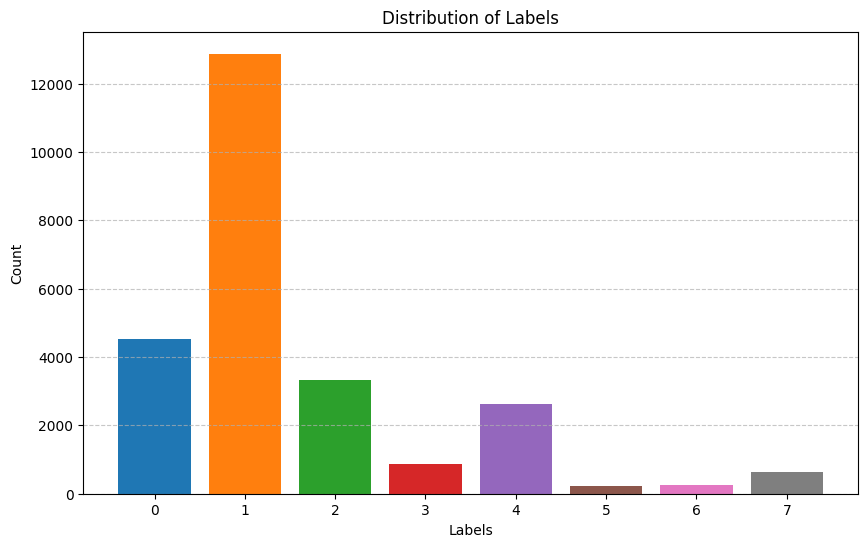

In [11]:
plot_label_distribution(images, labels)

25331 25331


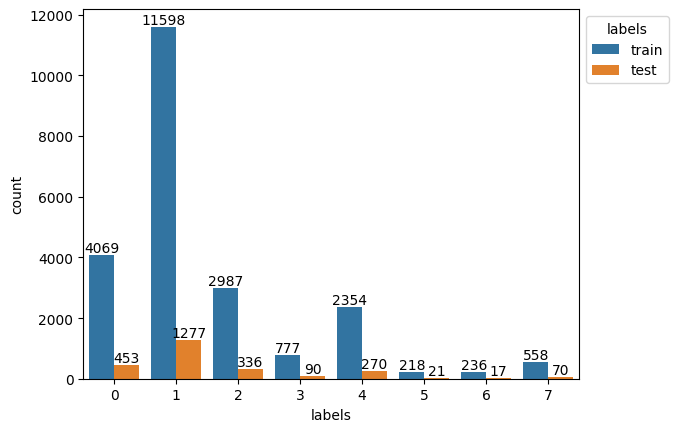

In [12]:
number_train_images = int(len(images) * 0.9)
train_images, train_labels = images[:number_train_images], labels[:number_train_images]
test_images, test_labels = images[number_train_images:], labels[number_train_images:]

cur_labels = train_labels + test_labels
splits = ['train' for _ in range(len(train_labels))] + ['test' for _ in range(len(test_labels))] 
print(len(labels), len(splits))
df = pd.DataFrame(list(zip(cur_labels, splits)),
               columns =['labels', 'splits'])

p = sns.countplot(data=df, x='labels', hue='splits')
p.legend(title='labels', bbox_to_anchor=(1, 1), loc='upper left')

for c in p.containers:
    # set the bar label
    p.bar_label(c, fmt='%.0f', label_type='edge')

In [13]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [260, 260], 'nearest')
    image = tf.cast(image, tf.float32) / 255.0
    return image

def data_augment(image, label, minority_threshold=2000):
    # Áp dụng augmentation cho tất cả ảnh, nhưng tăng cường cho lớp thiểu số
    image = tf.cast(image, tf.float32)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_left_right(image)
        if label < minority_threshold:  # Chỉ áp dụng thêm cho lớp thiểu số
            image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_crop(image, size=[240, 240, 3])
            image = tf.image.resize(image, [260, 260])
    return image, label   

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label

# over-sampling
def create_balanced_dataset(images, labels, minority_threshold=2000, batch_size=10):
    # Tách thành các dataset theo nhãn
    unique_labels = sorted(set(labels))
    datasets = []
    for label in unique_labels:
        mask = [l == label for l in labels]
        ds = tf.data.Dataset.from_tensor_slices(([images[i] for i in range(len(mask)) if mask[i]], [labels[i] for i in range(len(mask)) if mask[i]]))
        ds = ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)
        # Lặp lại lớp thiểu số để tăng số lượng
        repeat_times = 5 if label >= minority_threshold else 1
        ds = ds.repeat(repeat_times)
        ds = ds.map(lambda x, y: data_augment(x, y), num_parallel_calls=tf.data.AUTOTUNE)

        datasets.append(ds)
    
    # Kết hợp các dataset với trọng số bằng nhau
    balanced_ds = tf.data.experimental.sample_from_datasets(
        datasets,
        weights=[1.0] * len(unique_labels),
        stop_on_empty_dataset=False
    )
    return balanced_ds.shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Sử dụng
train_ds = create_balanced_dataset(train_images, train_labels)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(10).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1756955407.776132      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756955407.776922      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 50

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [16]:
model = keras.applications.EfficientNetB2(include_top=True)

# for input you can also do model.input,
# then for base_outputs you can obviously
# choose other than simply removing the last one :)
base_inputs = model.layers[0].input
base_outputs = model.layers[-1].output
classifier = layers.Dense(classes)(base_outputs)
# new_model = keras.Model(inputs=base_inputs, outputs=classifier)


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=False),],
    metrics=["sparse_categorical_accuracy"],
)

37432240/37432240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=16,
    epochs=EPOCHS,
    verbose=1,
    callbacks=lr_callback,
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50


I0000 00:00:1756955520.192509      66 service.cc:148] XLA service 0x793434008ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756955520.194105      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756955520.194135      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756955528.318175      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1756955536.350037      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756955536.502983      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756955536.652965      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

      1/Unknown 166s 166s/step - loss: 7.6485 - sparse_categorical_accuracy: 0.0000e+00

I0000 00:00:1756955579.857913      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   2279/Unknown 395s 101ms/step - loss: 3.8633 - sparse_categorical_accuracy: 0.2989

E0000 00:00:1756955822.815113      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756955822.960122      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756955827.841884      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756955827.978686      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   2280/Unknown 453s 126ms/step - loss: 3.8624 - sparse_categorical_accuracy: 0.2990

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
E0000 00:00:1756955894.952549      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756955895.100634      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 486s 141ms/step - loss: 3.8616 - sparse_categorical_accuracy: 0.2991 - val_loss: 2.3664 - val_sparse_categorical_accuracy: 0.5043 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 263s 111ms/step - loss: 1.6276 - sparse_categorical_accuracy: 0.4898 - val_loss: 2.0185 - val_sparse_categorical_accuracy: 0.5335 - learning_rate: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.0000000000000004e-05.
Epoch 3/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 260s 110ms/step - loss: 1.2993 - sparse_categorical_accuracy: 0.5658 - val_loss: 1.7166 - val_sparse_categorical_accuracy: 0.5639 - learning_rate: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 4e-05.
Epoch 4/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 260s 110ms/step - loss: 1.1524 - sparse_categorical_accuracy: 0.6103 - val_loss: 1.9756 - val_sparse_categorical_accuracy: 0.5631 - learning_rate: 4.0000e-05

E

In [18]:
model.save("final_model.h5")